In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import SVC



import numpy as np

## Exploration

In [2]:
df = pd.read_csv("heart.csv")

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
male_1 = df[(df['Sex']=='M') & (df['HeartDisease']==1)]

In [6]:
female_1 = df[(df['Sex']=='F') & (df['HeartDisease']==1)]

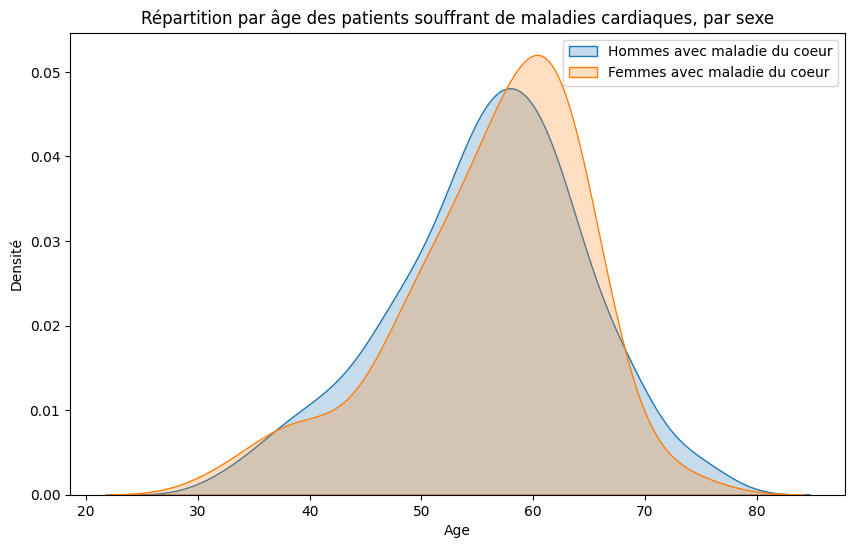

In [7]:
plt.figure(figsize=(10, 6))
sns.kdeplot(male_1['Age'], label='Hommes avec maladie du coeur', fill=True)
sns.kdeplot(female_1['Age'], label='Femmes avec maladie du coeur', fill=True)
plt.title('Répartition par âge des patients souffrant de maladies cardiaques, par sexe')
plt.xlabel('Age')
plt.ylabel('Densité')
plt.legend()
plt.show()

In [8]:
df.select_dtypes(int, float)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,HeartDisease
0,40,140,289,0,172,0
1,49,160,180,0,156,1
2,37,130,283,0,98,0
3,48,138,214,0,108,1
4,54,150,195,0,122,0
...,...,...,...,...,...,...
913,45,110,264,0,132,1
914,68,144,193,1,141,1
915,57,130,131,0,115,1
916,57,130,236,0,174,1


In [9]:
df.select_dtypes(object)

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,Normal,N,Up
1,F,NAP,Normal,N,Flat
2,M,ATA,ST,N,Up
3,F,ASY,Normal,Y,Flat
4,M,NAP,Normal,N,Up
...,...,...,...,...,...
913,M,TA,Normal,N,Flat
914,M,ASY,Normal,N,Flat
915,M,ASY,Normal,Y,Flat
916,F,ATA,LVH,N,Flat


In [10]:
def encode_columns(df, column_name):
  oh = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
  encoded_data = oh.fit_transform(df[[column_name]])
  encoded_df = pd.DataFrame(encoded_data, columns=[f"{column_name}_{cat}" for cat in oh.categories_[0]])
  df = pd.concat([df, encoded_df], axis=1)
  df.drop(columns=[column_name], inplace=True)
  return df

In [11]:
for col in df.columns:
  if df[col].dtype == "object":
    df = encode_columns(df, col)

In [12]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,160,180,0,156,1.0,1,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,130,283,0,98,0.0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,48,138,214,0,108,1.5,1,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,54,150,195,0,122,0.0,0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [13]:
df.corr()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
Age,1.000000,0.254399,-0.095282,0.198039,-0.382045,0.258612,0.282039,-0.055750,0.055750,0.166607,...,-0.011335,0.032042,0.145727,-0.230566,0.136798,-0.215793,0.215793,0.138397,0.185568,-0.258067
RestingBP,0.254399,1.000000,0.100893,0.070193,-0.112135,0.164803,0.107589,-0.005133,0.005133,0.048824,...,-0.041348,0.049855,0.053166,-0.116851,0.090447,-0.155101,0.155101,-0.007912,0.099207,-0.096146
Cholesterol,-0.095282,0.100893,1.000000,-0.260974,0.235792,0.050148,-0.232741,0.200092,-0.200092,-0.120531,...,-0.006634,0.017365,0.177077,-0.038470,-0.133106,0.034166,-0.034166,-0.083371,-0.050953,0.094027
FastingBS,0.198039,0.070193,-0.260974,1.000000,-0.131438,0.052698,0.267291,-0.120076,0.120076,0.131176,...,-0.039249,0.026885,-0.011656,-0.093028,0.127110,-0.060451,0.060451,0.105102,0.107006,-0.161730
MaxHR,-0.382045,-0.112135,0.235792,-0.131438,1.000000,-0.160691,-0.400421,0.189186,-0.189186,-0.354963,...,0.134580,0.100025,0.125793,0.023801,-0.157879,0.370425,-0.370425,-0.073316,-0.342581,0.383397
Oldpeak,0.258612,0.164803,0.050148,0.052698,-0.160691,1.000000,0.403951,-0.105734,0.105734,0.280026,...,-0.106212,0.032231,0.086794,-0.116719,0.055958,-0.408752,0.408752,0.322130,0.283295,-0.450577
HeartDisease,0.282039,0.107589,-0.232741,0.267291,-0.400421,0.403951,1.000000,-0.305445,0.305445,0.516716,...,-0.212964,-0.054790,0.010670,-0.091580,0.102527,-0.494282,0.494282,0.122527,0.554134,-0.622164
Sex_F,-0.055750,-0.005133,0.200092,-0.120076,0.189186,-0.105734,-0.305445,1.000000,-1.000000,-0.183876,...,0.066486,0.004031,0.049518,0.010634,-0.063715,0.190664,-0.190664,-0.066036,-0.116077,0.150942
Sex_M,0.055750,0.005133,-0.200092,0.120076,-0.189186,0.105734,0.305445,-1.000000,1.000000,0.183876,...,-0.066486,-0.004031,-0.049518,-0.010634,0.063715,-0.190664,0.190664,0.066036,0.116077,-0.150942
ChestPainType_ASY,0.166607,0.048824,-0.120531,0.131176,-0.354963,0.280026,0.516716,-0.183876,0.183876,1.000000,...,-0.577670,-0.249003,0.002289,-0.063606,0.076438,-0.430034,0.430034,0.103407,0.303645,-0.359443


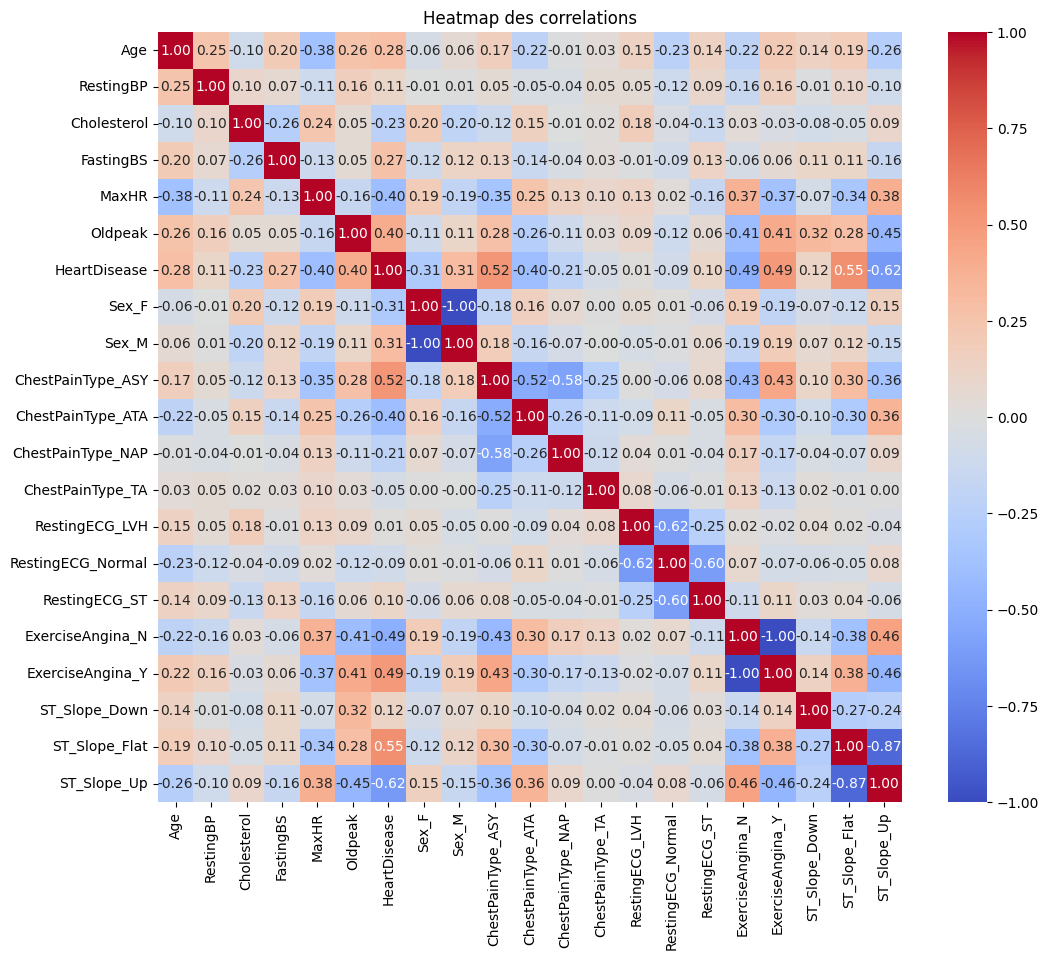

In [14]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap des correlations')
plt.show()

In [15]:
#new_df = df[['Age', 'RestingBP', 'FastingBS', 'Oldpeak', 'encoded_Sex', 'encoded_ExerciseAngina']]
#new_df = df[['Oldpeak', 'encoded_ExerciseAngina', 'encoded_Sex']]
#new_df = df[['Age', 'Oldpeak', 'FastingBS', 'encoded_ExerciseAngina', 'encoded_Sex']]
#new_df = df[['Oldpeak', 'encoded_ExerciseAngina']]
new_df = df[['Oldpeak', 'ChestPainType_ASY', 'ExerciseAngina_Y', 'ST_Slope_Flat']]

In [16]:
new_df.head()

,Oldpeak,ChestPainType_ASY,ExerciseAngina_Y,ST_Slope_Flat
0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0
3,1.5,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


## KNNClassifier

In [17]:
X = new_df
y = df['HeartDisease']
score = []
best_k = 0
best_score = 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

for k in range(2, 30):
  model = KNeighborsClassifier(n_neighbors=k)

  model.fit(X_train, y_train)

  val_score = model.score(X_val, y_val)
  score.append(val_score)

  if val_score > best_score:
    best_score = val_score
    best_k = k

print(best_k)
print(best_score)

12
0.8775510204081632


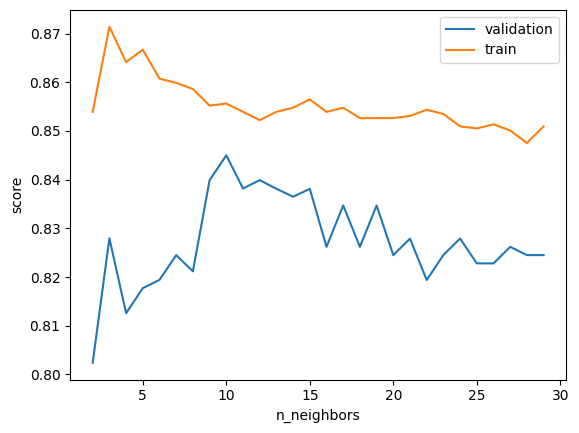

In [18]:
model = KNeighborsClassifier()
k = np.arange(2, 30)

train_score, val_score = validation_curve(estimator=model,
                                          X=X_train,
                                          y=y_train,
                                          param_name = "n_neighbors",
                                          param_range=k,
                                          cv=5)

plt.plot(k, val_score.mean(axis=1), label="validation")
plt.plot(k, train_score.mean(axis=1), label="train")
plt.ylabel("score")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()

In [19]:
final_model = KNeighborsClassifier(n_neighbors=10)
final_model.fit(X_train, y_train)
final_acc = final_model.score(X_test, y_test)
print(f"Précision sur l'ensemble de test du modèle KNN avec le meilleur k ({10}) : {final_acc:.2f}%")

Précision sur l'ensemble de test du modèle KNN avec le meilleur k (10) : 0.82%


In [20]:
y_pred = final_model.predict(X_test)

In [21]:
print("Precision:", precision_score(y_test,
                                    y_pred,
                                    average="weighted"))

Precision: 0.8222370773376199


In [22]:
print("Recall:", recall_score(y_test,
                              y_pred,
                              average='weighted'))

Recall: 0.8152173913043478


In [23]:
print('F1 score:', f1_score(y_test,
                            y_pred,
                            average="weighted"))

F1 score: 0.8163220219158714


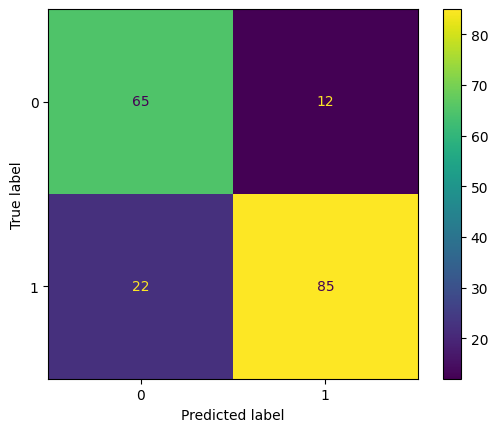

In [24]:
confusion_matrix = metrics.confusion_matrix(y_test,
                                            y_pred)

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix,
    display_labels=[0, 1])

cm_display.plot()
plt.show()

In [25]:
knn = pickle.dumps(final_model)

In [63]:
joblib.dump(knn, 'knn.pkl')

['knn.pkl']

## Logistic Regression

In [26]:
X = new_df
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=43)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=43)

clf = LogisticRegression(max_iter=10000, random_state=0)
clf.fit(X_train, y_train)

acc = accuracy_score(y_val, clf.predict(X_val)) * 100
print(f"Précision sur l'ensemble de validation du modèle Logistic Regression : {acc:.2f}%")

Précision sur l'ensemble de validation du modèle Logistic Regression : 80.95%


In [27]:
final_acc = accuracy_score(y_test, clf.predict(X_test)) * 100
print(f"Précision sur l'ensemble de test du modèle Logistic Regression : {final_acc:.2f}%")

Précision sur l'ensemble de test du modèle Logistic Regression : 82.07%


In [28]:
y_pred = clf.predict(X_test)

In [29]:
print("Precision:", precision_score(y_test,
                                    y_pred,
                                    average="weighted"))

Precision: 0.8209263822177865


In [30]:
print("Recall:", recall_score(y_test,
                              y_pred,
                              average="weighted"))

Recall: 0.8206521739130435


In [31]:
print('F1 score:', f1_score(y_test, y_pred,
                            average="weighted"))

F1 score: 0.8207648868966683


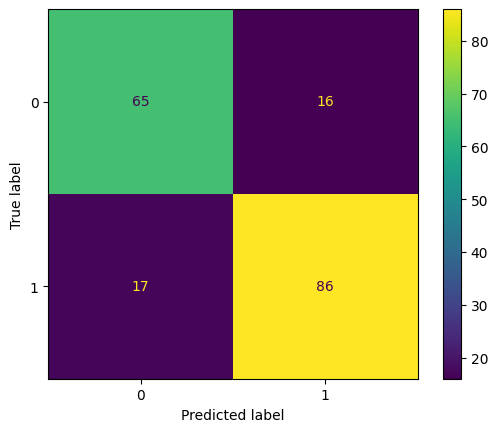

In [32]:
confusion_matrix = metrics.confusion_matrix(y_test,
                                            y_pred)

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix,
    display_labels=[0, 1])

cm_display.plot()
plt.show()

In [33]:
lr = pickle.dumps(clf)

In [64]:
joblib.dump(lr, 'logistic_regression.pkl')

['logistic_regression.pkl']

## Suport Vector Machine (SVM)

In [34]:
X = new_df
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=43)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=43)

svm = SVC(kernel='rbf', gamma=0.5, C=1.0)
svm.fit(X_train, y_train)

acc = accuracy_score(y_val, svm.predict(X_val))*100

In [35]:
print(f"Précision sur l'ensemble de validation du modèle Suport Vector Machine : {acc:.2f}%")

Précision sur l'ensemble de validation du modèle Suport Vector Machine : 84.35%


In [36]:
final_acc = accuracy_score(y_test, svm.predict(X_test)) * 100
print(f"Précision sur l'ensemble de test du modèle Suport Vector Machine : {final_acc:.2f}%")

Précision sur l'ensemble de test du modèle Suport Vector Machine : 80.98%


In [37]:
y_pred = svm.predict(X_test)

In [38]:
print("Précision:", accuracy_score(y_test,
                                   y_pred))

Précision: 0.8097826086956522


In [39]:
print("Recall:", recall_score(y_test, y_pred, average="weighted"))

Recall: 0.8097826086956522


In [40]:
print("F1 score:", f1_score(y_test, y_pred,
                            average="weighted"))

F1 score: 0.8099021527691938


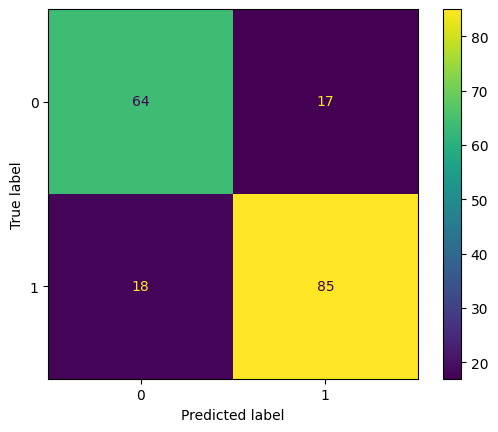

In [41]:
confusion_matrix = metrics.confusion_matrix(y_test,
                                            y_pred)

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix,
    display_labels=[0, 1])

cm_display.plot()
plt.show()

In [42]:
svm = pickle.dumps(svm)

In [65]:
joblib.dump(svm, 'suport_vector_machine.pkl')

['suport_vector_machine.pkl']

## Decision Tree

In [43]:
X = new_df
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=43)

model = DecisionTreeClassifier(criterion="gini",
                               random_state=100,
                               max_depth=3,
                               min_samples_leaf=5)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=100)

In [44]:
acc = accuracy_score(y_val, model.predict(X_val))*100
print(f"Précision de l'ensemble de validation modèle Decision Tree : {acc:.2f}%")

Précision de l'ensemble de validation modèle Decision Tree : 83.67%


In [45]:
final_acc = accuracy_score(y_test, model.predict(X_test))*100
print(f"Précision de l'ensemble de test modèle Decision Tree : {final_acc:.2f}%")

Précision de l'ensemble de test modèle Decision Tree : 78.26%


In [46]:
y_pred = model.predict(X_test)

In [47]:
print("Precision:", precision_score(y_test,
                                    y_pred,
                                    average="weighted"))

Precision: 0.782168409466153


In [48]:
print("Recall:", recall_score(y_test,
                              y_pred,
                              average="weighted"))

Recall: 0.782608695652174


In [49]:
print("F1 score:", f1_score(y_test,
                            y_pred,
                            average="weighted"))

F1 score: 0.7822951505016722


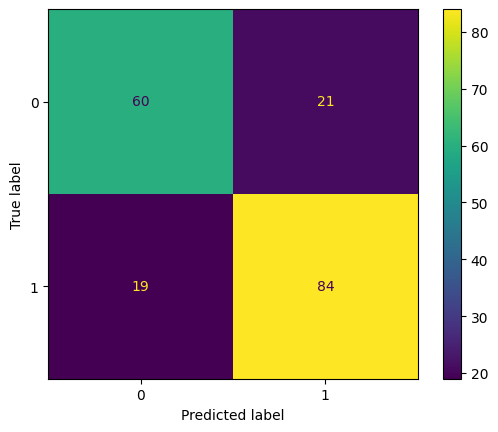

In [50]:
confusion_matrix = metrics.confusion_matrix(y_test,
                                            y_pred)
cm_display=metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix,
    display_labels=[0, 1]
)
cm_display.plot()
plt.show()

In [51]:
dt = pickle.dumps(model)

In [66]:
joblib.dump(dt, 'decision_tree.pkl')

['decision_tree.pkl']

## Random Forest

In [52]:
X = new_df
y = df['HeartDisease']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=43)

model = RandomForestClassifier(n_estimators=10, random_state=42, oob_score=True)

model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestClassifier(n_estimators=10, oob_score=True, random_state=42)

In [54]:
y_pred = model.predict(X_test)

In [55]:
acc = accuracy_score(y_val, model.predict(X_val))*100
print(f"Précision sur l'ensemble de validation du modèle Random Forest : {acc:.2f}%")

Précision sur l'ensemble de validation du modèle Random Forest : 85.03%


In [56]:
final_acc = accuracy_score(y_test, model.predict(X_test))*100
print(f"Précision sur l'ensemble de test du modèle Random Forest : {final_acc:.2f}%")

Précision sur l'ensemble de test du modèle Random Forest : 80.43%


In [57]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8043478260869565


In [58]:
print("Precision:", precision_score(y_test,
                                    y_pred,
                                    average="weighted"))
print("Recall:", recall_score(y_test,
                              y_pred,
                              average="weighted"))

Precision: 0.80717630875284
Recall: 0.8043478260869565


In [59]:
print("F1 score:", f1_score(y_test, y_pred, average="weighted"))

F1 score: 0.8049068322981366


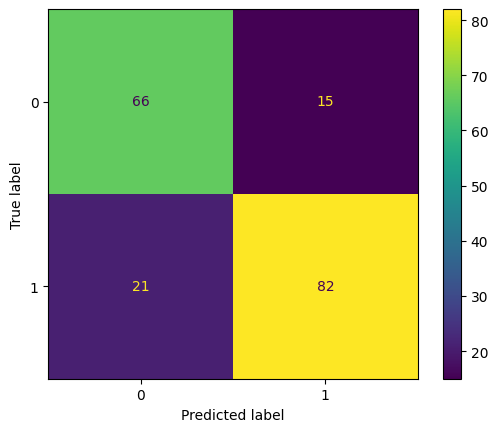

In [60]:
confusion_matrix = metrics.confusion_matrix(y_test,
                                            y_pred)
cm_display= metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix,
    display_labels=[0, 1]
)
cm_display.plot()
plt.show()

In [61]:
rt = pickle.dumps(model)

In [67]:
joblib.dump(rt, 'random_forest.pkl')

['random_forest.pkl']